# Method Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 06.01.2023
- **Date of Last Modification:** 14.01.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
import sys
sys.path.append("../../autotalker")

In [2]:
from datetime import datetime

import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scib

from autotalker.benchmarking import compute_benchmarking_metrics

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=62, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.0.18', 42326), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=62, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.0.18', 42330), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=62, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.0.18', 42332), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/c

### 1.2 Define Parameters

In [3]:
dataset = "seqfish_mouse_organogenesis_embryo2"
cell_type_key = "celltype_mapped_refined"
spatial_key = "spatial"
random_seed = 0

### 1.3 Run Notebook Setup

In [4]:
sc.set_figure_params(figsize=(6, 6))

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [5]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Directories

In [6]:
data_folder_path = "../datasets/srt_data/gold/"
figure_folder_path = f"../figures/method_benchmarking/{dataset}/"

### 1.5 Define Functions

In [7]:
def compute_combined_benchmarking_metrics(model_adata,
                                          model_name,
                                          spatial_model,
                                          run_number_list=list(np.arange(1, 11)),
                                          n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                                          cell_type_key="celltype_mapped_refined"):
    benchmarking_dict_list = []
    for run_number, n_neighbors in zip(run_number_list, n_neighbors_list):
        
        # Compute Autotalker metrics
        benchmarking_dict = compute_benchmarking_metrics(adata=model_adata,
                                                         spatial_model=spatial_model,
                                                         latent_key=f"{model_name}_latent_run{run_number}",
                                                         active_gp_names_key=f"{model_name}_active_gp_names_run{run_number}",
                                                         cell_type_key=cell_type_key,
                                                         spatial_key="spatial",
                                                         spatial_knng_key = f"{model_name}_spatial_{n_neighbors}nng",
                                                         latent_knng_key = f"{model_name}_latent_{n_neighbors}nng",
                                                         n_neighbors=n_neighbors)

        # Compute scib metrics
        sc.pp.neighbors(adata=model_adata,
                        use_rep=f"{model_name}_latent_run{run_number}",
                        n_neighbors=15) # default
        scib.me.cluster_optimal_resolution(adata=model_adata,
                                           cluster_key="cluster",
                                           label_key=cell_type_key)
        benchmarking_dict["ari"] = scib.me.ari(model_adata,
                                               cluster_key="cluster",
                                               label_key=cell_type_key)
        benchmarking_dict["clisi"] = scib.me.clisi_graph(adata=model_adata,
                                                         label_key=cell_type_key,
                                                         type_="embed",
                                                         use_rep=f"{model_name}_latent_run{run_number}")
        benchmarking_dict["nmi"] = scib.me.nmi(adata=model_adata,
                                               cluster_key="cluster",
                                               label_key=cell_type_key)
        benchmarking_dict["asw"] = scib.me.silhouette(adata=model_adata,
                                                      label_key=cell_type_key,
                                                      embed=f"{model_name}_latent_run{run_number}")
        benchmarking_dict["isolated_labels_asw"] = scib.me.isolated_labels_asw(adata=model_adata,
                                                                               batch_key="sample",
                                                                               label_key=cell_type_key,
                                                                               embed=f"{model_name}_latent_run{run_number}")
        
        benchmarking_dict["model_name"] = model_name
        benchmarking_dict["run"] = run_number
        benchmarking_dict_list.append(benchmarking_dict)
    return benchmarking_dict_list

## 2. Data

In [ ]:
# Load data after running all notebooks in the 'method_benchmarking' folder
adata_pca = sc.read_h5ad(data_folder_path + f"{dataset}_pca.h5ad")
adata_scvi = sc.read_h5ad(data_folder_path + f"{dataset}_scvi.h5ad")
adata_expimap = sc.read_h5ad(data_folder_path + f"{dataset}_expimap.h5ad")
adata_sagenet = sc.read_h5ad(data_folder_path + f"{dataset}_sagenet.h5ad")
adata_deeplinc = sc.read_h5ad(data_folder_path + f"{dataset}_deeplinc.h5ad")
adata_graphst = sc.read_h5ad(data_folder_path + f"{dataset}_graphst.h5ad")
adata_autotalker = sc.read_h5ad(data_folder_path + f"{dataset}_autotalker.h5ad")

In [8]:
adata_deeplinc = sc.read_h5ad(data_folder_path + f"{dataset}_deeplinc.h5ad")

## 3. Method Benchmarking

### 3.1 PCA

- Evaluate PCA of log normalized gene expression.
- Run ```method_benchmarking/pca/pca.ipynb``` before evaluation.

In [ ]:
benchmarking_dict_list_pca = compute_combined_benchmarking_metrics(model_adata=adata_pca,
                                                                   model_name="pca",
                                                                   spatial_model=False,
                                                                   run_number_list=[1],
                                                                   n_neighbors_list=[12],
                                                                   cell_type_key="celltype_mapped_refined")

In [ ]:
del(adata_pca)

### 3.2 scVI

- Evaluate scVI.
- Run ```method_benchmarking/scvi/scvi.ipynb``` before evaluation.

In [ ]:
benchmarking_dict_list_scvi = compute_combined_benchmarking_metrics(model_adata=adata_scvi,
                                                                    model_name="scvi",
                                                                    spatial_model=False,
                                                                    run_number_list=list(np.arange(1, 2)),
                                                                    n_neighbors_list=[4],
                                                                    cell_type_key="celltype_mapped_refined")

In [ ]:
del(adata_scvi)

### 3.3 expiMap

- Evaluate expiMap.
- Run ```method_benchmarking/expimap/expimap.ipynb``` before evaluation.

In [ ]:
benchmarking_dict_list_expimap = compute_combined_benchmarking_metrics(model_adata=adata_expimap,
                                                                       model_name="expimap",
                                                                       spatial_model=False,
                                                                       run_number_list=list(np.arange(1, 2)),
                                                                       n_neighbors_list=[4],
                                                                       cell_type_key="celltype_mapped_refined")

In [ ]:
del(adata_expimap)

### 3.4 SageNet

- Evaluate SageNet.
- Run ```method_benchmarking/sagenet/sagenet.ipynb``` before evaluation.

In [ ]:
import scipy.sparse as sp
adata_sagenet.X = sp.csr_matrix(adata_sagenet.X)

# Label all 'gene programs' as active gene programs for subsequent benchmarking
for run_number in range(10):
    adata_sagenet.uns[f"sagenet_active_gp_names_run{run_number + 1}"] = (
        np.array([f"latent_{i}" for i in range(adata_sagenet.obsm[f"sagenet_latent_run{run_number + 1}"].shape[1])]))

In [ ]:
adata_sagenet.write(f"{data_folder_path}/{dataset}_sagenet.h5ad") 

In [ ]:
del(adata_sagenet)

### 3.5 DeepLinc

In [9]:
benchmarking_dict_list_deeplinc = compute_combined_benchmarking_metrics(model_adata=adata_deeplinc,
                                                                        model_name="deeplinc",
                                                                        spatial_model=True,
                                                                        run_number_list=list(np.arange(1, 2)),
                                                                        n_neighbors_list=[4],
                                                                        cell_type_key="celltype_mapped_refined")

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.43625205848769655
resolution: 0.2, nmi: 0.4256497541226183
resolution: 0.3, nmi: 0.4354678447390657
resolution: 0.4, nmi: 0.4485325608489123
resolution: 0.5, nmi: 0.4475305564455195
resolution: 0.6, nmi: 0.44626262488014123
resolution: 0.7, nmi: 0.4494230780105263
resolution: 0.8, nmi: 0.4456513556761488
resolution: 0.9, nmi: 0.4431506552761424
resolution: 1.0, nmi: 0.4444155442721347
resolution: 1.1, nmi: 0.4439504771040337
resolution: 1.2, nmi: 0.4466912134575003
resolution: 1.3, nmi: 0.4407771257462492
resolution: 1.4, nmi: 0.4483105432868993
resolution: 1.5, nmi: 0.4520939220675786
resolution: 1.6, nmi: 0.4489948038021931
resolution: 1.7, nmi: 0.4467223731441045
resolution: 1.8, nmi: 0.4514085671173903
resolution: 1.9, nmi: 0.4491425220828568
resolution: 2.0, nmi: 0.45359524591392275
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 2.0
optimal score: 0.45359524591392275
isolated labels: no more than 1 batches per label
Allanto

In [ ]:
del(adata_deeplinc)

### 3.6 GraphST

In [ ]:
benchmarking_dict_list_graphst = compute_combined_benchmarking_metrics(model_adata=adata_graphst,
                                                                       model_name="graphst",
                                                                       spatial_model=True,
                                                                       run_number_list=list(np.arange(1, 2)),
                                                                       n_neighbors_list=[4],
                                                                       cell_type_key="celltype_mapped_refined")

In [ ]:
del(adata_graphst)

### 3.7 Autotalker

In [ ]:
adata_autotalker.write(f"{data_folder_path}/{dataset}_autotalker.h5ad") 

In [ ]:
benchmarking_dict_list_autotalker = compute_combined_benchmarking_metrics(model_adata=adata_autotalker,
                                                                          model_name="autotalker",
                                                                          spatial_model=True,
                                                                          run_number_list=list(np.arange(1, 2)),
                                                                          n_neighbors_list=[4],
                                                                          #run_number_list=list(np.arange(1, 11)),
                                                                          #n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                                                                          cell_type_key="celltype_mapped_refined")

In [ ]:
del(adata_autotalker)

### 3.8 Summary

In [ ]:
benchmarking_dict_list = (benchmarking_dict_list_pca
                          + benchmarking_dict_list_scvi
                          + benchmarking_dict_list_expimap
                          # + benchmarking_dict_list_sagenet)
                          + benchmarking_dict_list_deeplinc
                          + benchmarking_dict_list_graphst
                          + benchmarking_dict_list_autotalker)

In [10]:
benchmarking_dict_list = benchmarking_dict_list_deeplinc

In [11]:
df = pd.DataFrame(benchmarking_dict_list)
df.head()

,gcd,mlnmi,cad,arclisi,germse,cca,ari,clisi,nmi,asw,isolated_labels_asw,model_name,run
0,214.683243,0.792441,51.780208,0.0,0.249541,0.850335,0.100362,0.980299,0.453595,0.464343,0.505143,deeplinc,1


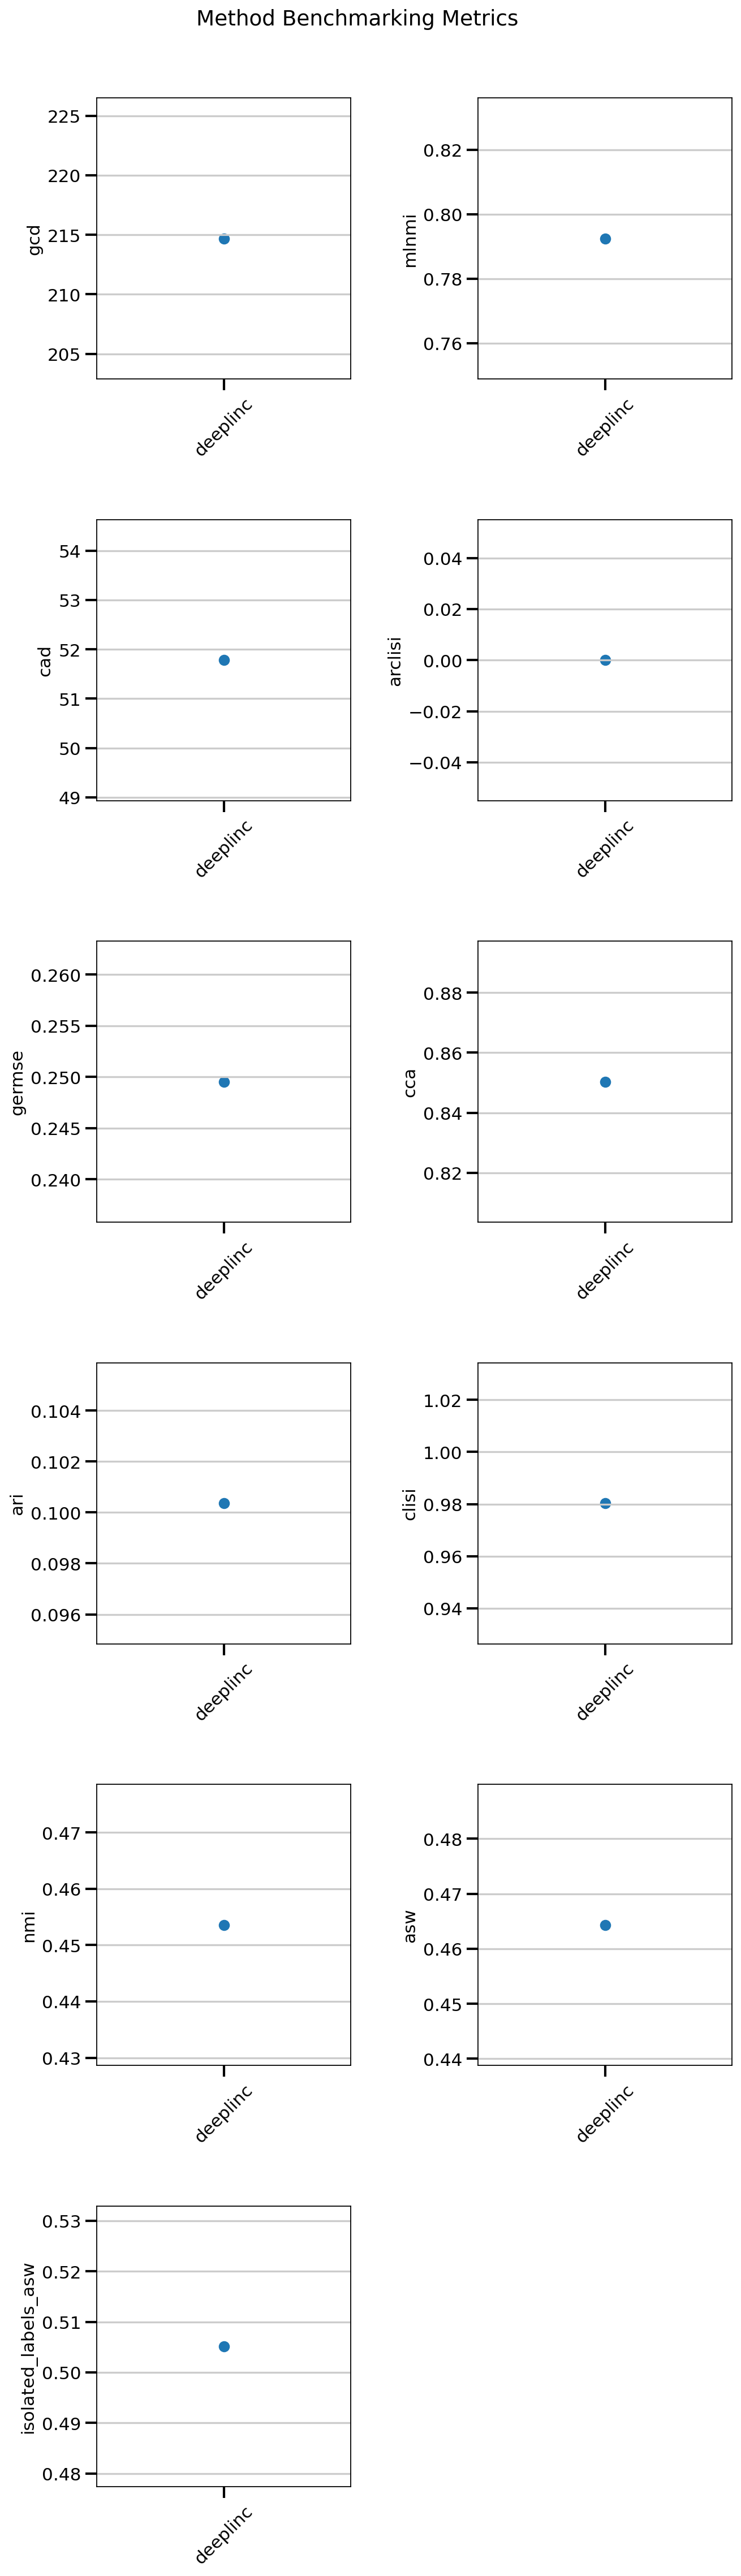

In [13]:
mean_df = df.groupby("model_name").mean()

columns = ["gcd",
           "mlnmi",
           "cad",
           "arclisi",
           "germse",
           "cca",
           "ari",
           "clisi",
           "nmi",
           "asw",
           "isolated_labels_asw"]


fig, axs = plt.subplots(nrows=int(np.ceil(len(columns)/2)), ncols=2, figsize=(9, 3*len(columns)))
axs=axs.flatten()

for i, col in enumerate(columns):
    sns.pointplot(data=mean_df, x=mean_df.index, y=col, ax=axs[i])
    axs[i].set_xlabel('')
    xlabels = axs[i].get_xticks()
    axs[i].set_xticklabels(mean_df.index, rotation=45)
plt.suptitle("Method Benchmarking Metrics")
plt.subplots_adjust(hspace=0.5, wspace=0.5, top=0.95)

if len(columns) % 2 != 0:
    fig.delaxes(axs[-1])

plt.show()

In [ ]:
adata_deeplinc

In [ ]:
sc.pp.neighbors(adata=adata_deeplinc,
                use_rep="deeplinc_latent_run1",
                n_neighbors=20,
                random_state=0,
                key_added="hogopogo")

In [ ]:
import squidpy as sq
sq.gr.nhood_enrichment(adata_deeplinc,
                       cluster_key=cell_type_key,
                       connectivity_key="hogopogo",
                       n_perms=1000,
                       seed=0,
                       show_progress_bar=False)

In [ ]:
adata_deeplinc.uns["celltype_mapped_refined_nhood_enrichment"]

In [ ]:
nhood_enrichment_zscores_diff = (
        adata_deeplinc.uns[f"{cell_type_key}_latent_nhood_enrichment"]["zscore"] -
        adata_deeplinc.uns[f"{cell_type_key}_spatial_nhood_enrichment"]["zscore"])

In [ ]:
nhood_enrichment_zscores_diff.shape

In [ ]:
nhood_enrichment_zscores_diff.shape

In [ ]:
nhood_enrichment_zscores_diff

In [ ]:
    cad = np.linalg.norm(nhood_enrichment_zscores_diff)

In [ ]:
cad

In [ ]:
nhood_enrichment_zscores_diff = nhood_enrichment_zscores_diff[~np.isnan(nhood_enrichment_zscores_diff)]

In [ ]:
import squidpy as sq
sq.gr.nhood_enrichment(adata_deeplinc,
                       cluster_key=cell_type_key,
                       connectivity_key="hogopogo",
                       n_perms=1000,
                       seed=0,
                       show_progress_bar=False)

In [ ]:
adata_deeplinc.obsp["deeplinc_latent_4nng_connectivities"].toarray().sum(axis=0)

In [ ]:
from autotalker.utils import compute_graph_connectivities

adata_deeplinc.obsp["test"] = (
    compute_graph_connectivities(
        adata=adata_deeplinc,
        feature_key="deeplinc_latent_run1",
        n_neighbors=4,
        mode="knn",
        seed=0))

In [ ]:
adata_deeplinc.obsp["test"].sum(axis=0)

In [ ]:
adata_deeplinc.obsp["test"].sum(axis=1)

In [ ]:
adata_deeplinc.obsp["test"].toarray().sum(axis=0)

In [ ]:
adata_deeplinc.obsp["deeplinc_latent_4nng_connectivities"]

In [ ]:
distances

In [ ]:
(adata_deeplinc.obsm["test"].sum(axis=1) != 4).sum()

In [ ]:
sc.pp.neighbors(adata=adata_deeplinc, use_rep="deeplinc_latent_run1", key_added="test_nn")

In [ ]:
adata_deeplinc.obsp["test_nn_connectivities"].sum(axis=0)

In [ ]:
adata_deeplinc.obsp["test_nn_connectivities"].sum(axis=1)

In [ ]:
(adata_deeplinc.obsp["test_nn_connectivities"].sum(axis=1) == 0).sum()

In [ ]:
(adata_deeplinc.obsp["test_nn_connectivities"].sum(axis=0) == 0).sum()

In [ ]:
adata_deeplinc

In [ ]:
(adata_deeplinc.obsp["test3_connectivities"].toarray().sum(axis=0) == 0).sum()

In [ ]:
connectivities.sum(axis=0)

In [ ]:
    import squidpy as sq
    sq.gr.nhood_enrichment(adata_deeplinc,
                           cluster_key=cell_type_key,
                           connectivity_key="deeplinc_spatial_4nng",
                           n_perms=1000,
                           seed=0,
                           show_progress_bar=False)

In [ ]:
import scipy.sparse as sp
sp.csr_matrix(adata_deeplinc.X)